※開発環境はGoogleColabです。

※Flaskを利用した簡単なwebアプリ
(ティッカーを入力するとPBR推移をグラフ表示してくれるwebアプリ)

In [ ]:
pip install flask-ngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install pyngrok

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.2/681.2 kB 11.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-6.0.0-py3-none-any.whl size=19867 sha256=f66f29efee222679f57ad8c72f65f3adb8eb25c906e792113895837af369cd22
  Stored in directory: /root/.cache/pip/wheels/5c/42/78/0c3d438d7f5730451a25f7ac6cbf4391759d22a67576ed7c2c
Successfully built pyngrok


In [ ]:
!ngrok authtoken 2PpZDo2bmgfzmMzJ7JUJygYqGk8_65PPrsCudD6e6yipr1pGr

Authtoken saved to configuration file: /root/.ngrok2/ngrok.yml


In [ ]:
#Google認証
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

In [ ]:
pip install yahooquery

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.8/49.8 kB 2.0 MB/s eta 0:00:00


In [ ]:
from yahooquery import Ticker

import pandas_datareader.data as web
import datetime as dt

from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def PBR(ticker):
    # ====まずは東証プライム全銘柄のBSデータをデータフレームとして取得====

    #spreadsheetを開く（BSデータ）
    url = "https://docs.google.com/spreadsheets/d/1SxMC3GUKHCHCPUX4NTuhU6rDeVrmR3aIMqA-hNVJbIc/edit#gid=1407125800"
    ss = gc.open_by_url(url)

    sheet3 = ss.get_worksheet(2) #3枚目のシート取得
    all_values_bs = sheet3.get_all_values() # シートの全データを取得
    df_bs = pd.DataFrame.from_records(all_values_bs) # pandasで読み込み

    # 1行目が列名になっているので、列名に変換して1行目は削除
    new_columns = df_bs.iloc[0, :] # 1行目の値を取得する
    df_bs = df_bs.rename(columns=new_columns) # 列の名前を変更する
    df_bs = df_bs.drop(0) #1行目は削除
    # 必要な列のみ抽出
    desired_columns = ["symbol", "asOfDate", "StockholdersEquity", "ShareIssued"]
    df_bs = df_bs[desired_columns]
    # 日付をobjectからdatetimeに変換
    df_bs["asOfDate"] = pd.to_datetime(df_bs["asOfDate"]) 
    # 欠損値2点のある行を削除
    df_bs = df_bs.drop(df_bs[(df_bs["symbol"] == "3053.T") & (df_bs["asOfDate"].dt.year == 2019)].index)
    df_bs = df_bs.drop(df_bs[(df_bs["symbol"] == "7944.T") & (df_bs["asOfDate"].dt.year == 2019)].index)
    # StockholdersEquity(株主資本)とShareIssued(発行済み株式数)をstrからfloatに変更
    df_bs["StockholdersEquity"] = df_bs["StockholdersEquity"].astype(float)
    df_bs["ShareIssued"] = df_bs["ShareIssued"].astype(float)


    # ====ここから先は、求めたいtickerについての情報処理====

    # df_bsからtickerの情報のみを抽出
    ticker_t = str(ticker) + '.T'
    df_bs_ticker = df_bs[df_bs["symbol"] == ticker_t] # 該当銘柄の行をすべて抽出
    df_bs_ticker = df_bs_ticker.set_index('asOfDate') # 日付をindexに変更

    # tickerの株価取得
    start = df_bs_ticker.index[0]
    end = df_bs_ticker.index[-1] + pd.offsets.DateOffset(years=1) - pd.offsets.DateOffset(days=1) 

    price = Ticker(ticker_t).history(start=start, end=end).droplevel(level='symbol') # 株価取得
    price.index = pd.to_datetime(price.index) # indexをobjectからdatetimeに変換
    price = price.loc[:, "close"] # 終値だけ抽出

    # PBRを計算するための3要素を用意
    # PBR =　時価総額（株価price * 発行数ShareIssued） / 株主資本StockholdersEquity

    # 株主資本=se
    se_0 = df_bs_ticker.loc[df_bs_ticker.index[0], 'StockholdersEquity']
    if len(df_bs_ticker.index) > 1:
        se_1 = df_bs_ticker.loc[df_bs_ticker.index[1], 'StockholdersEquity']
    if len(df_bs_ticker.index) > 2:
        se_2 = df_bs_ticker.loc[df_bs_ticker.index[2], 'StockholdersEquity']
    if len(df_bs_ticker.index) > 3:
        se_3 = df_bs_ticker.loc[df_bs_ticker.index[3], 'StockholdersEquity']
    if len(df_bs_ticker.index) > 4:
        se_4 = df_bs_ticker.loc[df_bs_ticker.index[4], 'StockholdersEquity']

    # 株式発行数=si
    si_0 = df_bs_ticker.loc[df_bs_ticker.index[0], 'ShareIssued']
    if len(df_bs_ticker.index) > 1:
        si_1 = df_bs_ticker.loc[df_bs_ticker.index[1], 'ShareIssued']
    if len(df_bs_ticker.index) > 2:
        si_2 = df_bs_ticker.loc[df_bs_ticker.index[2], 'ShareIssued']
    if len(df_bs_ticker.index) > 3:
        si_3 = df_bs_ticker.loc[df_bs_ticker.index[3], 'ShareIssued']
    if len(df_bs_ticker.index) > 4:
        si_4 = df_bs_ticker.loc[df_bs_ticker.index[4], 'ShareIssued']

    # 株価=price
    price_0 = price[df_bs_ticker.index[0]:df_bs_ticker.index[1] - pd.offsets.DateOffset(days=1)]

    if len(df_bs_ticker.index) > 2:
        price_1 = price[df_bs_ticker.index[1]:df_bs_ticker.index[2] - pd.offsets.DateOffset(days=1)]
    elif len(df_bs_ticker.index) == 2:
        price_1 = price[df_bs_ticker.index[1]:df_bs_ticker.index[1] + pd.offsets.DateOffset(years=1)- pd.offsets.DateOffset(days=1)]
    else:
        price_1 = None

    if len(df_bs_ticker.index) > 3:
        price_2 = price[df_bs_ticker.index[2]:df_bs_ticker.index[3] - pd.offsets.DateOffset(days=1)]
    elif len(df_bs_ticker.index) == 3:
        price_2 = price[df_bs_ticker.index[2]:df_bs_ticker.index[2] + pd.offsets.DateOffset(years=1)- pd.offsets.DateOffset(days=1)]
    else:
        price_2 = None
        
    if len(df_bs_ticker.index) > 4:
        price_3 = price[df_bs_ticker.index[3]:df_bs_ticker.index[4] - pd.offsets.DateOffset(days=1)]
    elif len(df_bs_ticker.index) == 4:
        price_3 = price[df_bs_ticker.index[3]:df_bs_ticker.index[3] + pd.offsets.DateOffset(years=1)- pd.offsets.DateOffset(days=1)]
    else:
        price_3 = None

    prices = pd.concat([price_0, price_1, price_2, price_3]) 

    # PBRを計算
    pbr0 = price_0 * si_0 / se_0
    pbr1 = price_1 * si_1 / se_1
    if 'price_2' in locals() and 'si_2' in locals() and 'se_2' in locals():
        pbr2 = price_2 * si_2 / se_2
    else:
        pbr2 = None
    if 'price_3' in locals() and 'si_3' in locals() and 'se_3' in locals():
        pbr3 = price_3 * si_3 / se_3
    else:
        pbr3 = None

    # 求めた各年度のPBRを結合
    pbr_connect = pd.concat([pbr0, pbr1, pbr2, pbr3])
    
    return pbr_connect

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


 * Running on http://d5a1-34-171-20-42.ngrok-free.app
 * Traffic stats available on http://127.0.0.1:4040


INFO:werkzeug:127.0.0.1 - - [23/May/2023 19:52:16] "GET / HTTP/1.1" 404 -
ERROR:__main__:Exception on /favicon.ico [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 2529, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1825, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1823, in full_dispatch_request
    rv = self.dispatch_request()
  File "/usr/local/lib/python3.10/dist-packages/flask/app.py", line 1799, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)
  File "<ipython-input-27-270beeeff2b6>", line 13, in plot_graph
    df = PBR(ticker)
  File "<ipython-input-22-c1b1ce344fa4>", line 37, in PBR
    start = df_bs_ticker.index[0]
  File "/usr/local/lib/python3.10/dist-packages/pandas/core/indexes/base.py", line 5320, in __g

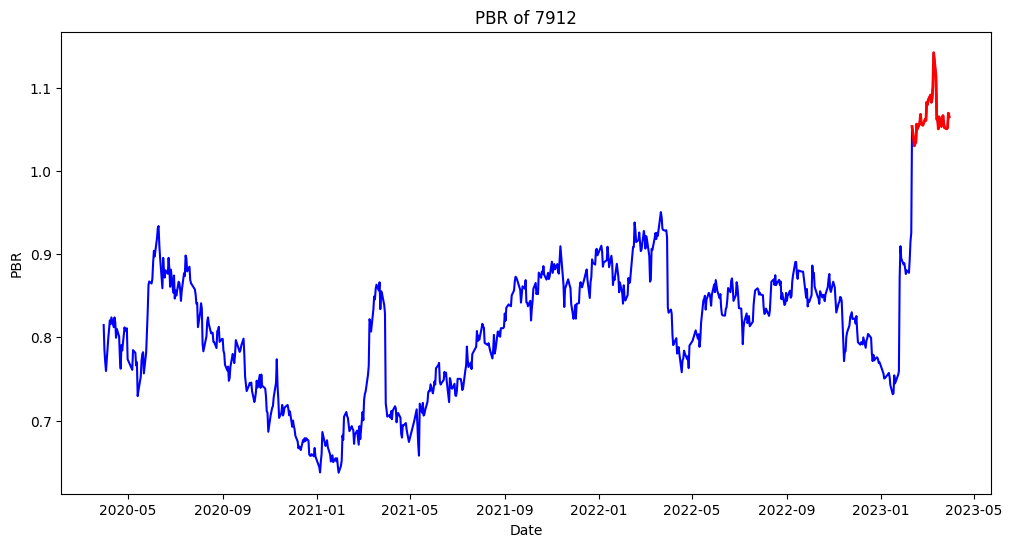

In [ ]:
from flask import Flask, Response
import pandas as pd
import matplotlib.pyplot as plt
from io import BytesIO
from flask_ngrok import run_with_ngrok

app = Flask(__name__)
run_with_ngrok(app)  # Start ngrok when app is run

@app.route("/<ticker>")
def plot_graph(ticker):
    
    df = PBR(ticker)

    fig, ax = plt.subplots(figsize=(12, 6))  # figsizeを変更する
    ax.plot(df.index, df.values, color='blue', label='PBR<1.0')
    ax.plot(df[df >= 1.0].index,
            df[df >= 1.0].values, color='red', linewidth=2.0, label='PBR>=1.0')
    ax.set_xlabel('Date')
    ax.set_ylabel('PBR')
    ax.set_title("PBR of " + str(ticker))
    
    # グラフを画像として保存
    image_stream = BytesIO()
    plt.savefig(image_stream, format='png')
    image_stream.seek(0)
    
    # 画像をHTTPレスポンスとして返す
    return Response(image_stream, mimetype='image/png')

if __name__ == '__main__':
    app.run()
